Around 25 minutes into [this lecture](https://www.youtube.com/watch?v=60fP4WJ4oxE), there is some good discussion of the PageRank algorithm. I have always wanted to code up a basic version of this algorithm, so this is a great excuse. This algorithm is probably one of the cleanest examples of Markov Chains that I have seen, and obviously its application was quite successful.
<!-- TEASER_END -->

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from utils import progress_bar_downloader
import os

pages_link = 'http://www.cs.ubc.ca/~nando/340-2009/lectures/pages.zip'
dlname = 'pages.zip'
#This will unzip into a directory called pages
if not os.path.exists('./%s' % dlname):
    progress_bar_downloader(pages_link, dlname)
    os.system('unzip %s' % dlname)
else:
    print('%s already downloaded!' % dlname)

pages.zip already downloaded!


Building the Matrix
-------------------

To build the link matrix (basically an adjacency matrix for web pages), we need to look at the links referenced by every single page. For every page referenced by a page, we will add a 1 to the associated column. Adding a small term `eps` to all entries, in order guarantee the matrix is fully connected, we will then have a stochastic matrix which is suitable for Markov chain simulations! 

In [3]:
#Quick and dirty link parsing as per http://www.cs.ubc.ca/~nando/540b-2011/lectures/book540.pdf
links = {}
for fname in os.listdir(dlname[:-4]):
    links[fname] = []
    f = open(dlname[:-4] + '/' + fname)
    for line in f.readlines():
        while True:
            p = line.partition('<a href="http://')[2]
            if p == '':
                break
            url, _, line = p.partition('\">')
            links[fname].append(url)
    f.close()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
num_pages = len(links.keys())
G = np.zeros((num_pages, num_pages))

#Assign identity numbers to each page, along with a reverse lookup
idx = {}
lookup = {}
for n,k in enumerate(sorted(links.keys())):
    idx[k] = n
    lookup[n] = k

#Go through all keys, and add a 1 for each link to another page
for k in links.keys():
    v = links[k]
    for e in v:
        G[idx[k],idx[e]] = 1

#Add a small value (epsilon) to ensure a fully connected graph
eps = 1. / num_pages
G += eps * np.ones((num_pages, num_pages))
G = G / np.sum(G, axis=1)

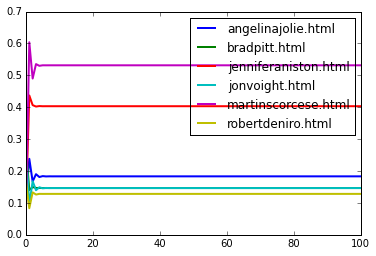

In [5]:
#Now we run the Markov Chain until it converges from random initialization
init = np.random.rand(1, num_pages)
init = init / np.sum(init)
probs = [init]
p = init
for i in range(100):
    p = np.dot(p, G)
    probs.append(p)

for i in range(num_pages):
    plt.plot([step[0, i] for step in probs], label=lookup[i], lw=2)
    
plt.legend()

Turn the Beat Around
--------------------

Now that the PageRank for each page is calculated, how can we actually perform a search?

We simply need to create an index of every word in a page. When we search for words, we will then sort the output by the PageRank of those pages, thus ordering the links by the *importance* we associated with that page.

In [6]:
search = {}
for fname in os.listdir(dlname[:-4]):
    f = open(dlname[:-4] + '/' + fname)
    for line in f.readlines():
        #Ignore header lines
        if '<' in line or '>' in line:
            continue
        words = line.strip().split(' ')
        words = filter(lambda x: x != '', words)
        #Remove references like [1], [2]
        words = filter(lambda x: not ('[' in x or ']' in x), words)

    for word in words:
        if word in search:
            if fname in search[word]:
                search[word][fname] += 1
            else:
                search[word][fname] = 1
        else:
            search[word] = {fname: 1}
    f.close()

Ranking The Results
-------------------

With words indexed, we can now complete the task. Searching for a particular word (in this case, 'film'), we get back all the pages with references and counts. Sorting these so that the highest pagerank comes first, we see the ***Googley***(TM) result for our tiny web.

In [7]:
def get_pr(fname):
    return probs[-1][0, idx[fname]]

r = search['film']
print(sorted(r, reverse=True, key=get_pr))

['martinscorcese.html', 'jenniferaniston.html', 'bradpitt.html', 'jonvoight.html']


This is a neat application of Markov chains and a great learning experience. Though this notebook did not touch on the eigendecomposition approaches and features of PageRank, it is most definitely worth looking into - check out the paper [The $25,000,000,000 Dollar Eigenvector](http://www.rose-hulman.edu/~bryan/googleFinalVersionFixed.pdf).

kk